In [12]:
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Dense,InputLayer,Dropout
from tensorflow.keras import Metric
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler 
%matplotlib inline
from sklearn.model_selection import train_test_split
import pickle,os


# 1. Préparation des données

In [13]:
# 1. Créer ou charger un DataFrame contenant le signal
df=pd.read_csv("df_merged.csv",index_col=0,nrows=14000)
Y_labels=df["TestResult"]
df=df.drop(columns="TestResult")
df=df.fillna(0)
# Remplacer les -inf par -10000
df.replace(-np.inf, -10000, inplace=True)

sc=StandardScaler()
dfs=sc.fit_transform(df)
pca=PCA(n_components=4000)
dfpca=pca.fit_transform(dfs)
# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(dfpca, Y_labels, test_size=0.1,train_size=0.9,random_state=42,stratify=Y_labels)
# Taille de l'entrée (nombre de composantes FFT réelles)
input_dim = dfpca.shape[1]  # Correspond à la longueur du vecteur FFT réel
print(input_dim)

4000


# 2 Définir l'architecture.

In [14]:
# Construire le modèle MLP
model = Sequential()
model.add(InputLayer(input_shape=(input_dim,)))
model.add(Dense(1024,activation='relu'))
# Deuxième couche dense
model.add(Dense(512, activation='relu'))
# Troisième couche dense
model.add(Dense(256, activation='relu'))
# Troisième couche dense
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
# Couche de sortie avec activation sigmoïde (classification binaire)
model.add(Dense(1, activation='sigmoid'))
# Compiler le modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Afficher le résumé du modèle
model.summary()

c:\Users\APINEL\source\Repos\CNI\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 1024)           │     4,097,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,790,209 (18.27 MB)

 Trainable params: 4,790,209 (18.27 MB)

 Non-trainable params: 0 (0.00 B)

# 3. Entraînement du modèle

Entraîne l'autoencodeur avec les données FFT normales (sans anomalies) pour qu'il apprenne à reconstruire efficacement ces données.

In [15]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                                        patience = 10,
                                        mode = 'min',
                                        restore_best_weights = True)

lr_plateau = ReduceLROnPlateau(monitor = 'val_loss',
                                        patience=5,
                                        factor=0.5,
                                        verbose=2,
                                        mode='min',
                                        min_lr = 1e-10) # type: ignore
checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [16]:
# Entraîner le modèle sur les données FFT
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2,callbacks=[model_checkpoint_callback,lr_plateau,early_stopping])

Epoch 1/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8824 - loss: 0.2703 - val_accuracy: 0.9580 - val_loss: 0.1287 - learning_rate: 0.0010
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9961 - loss: 0.0105 - val_accuracy: 0.9436 - val_loss: 0.2112 - learning_rate: 0.0010
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9984 - loss: 0.0062 - val_accuracy: 0.9619 - val_loss: 0.2723 - learning_rate: 0.0010
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9962 - loss: 0.0100 - val_accuracy: 0.9535 - val_loss: 0.2004 - learning_rate: 0.0010
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9975 - loss: 0.0071 - val_accuracy: 0.9565 - val_loss: 0.2844 - learning_rate: 0.0010
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9987 - loss: 0.0061
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9986 - loss: 0.0

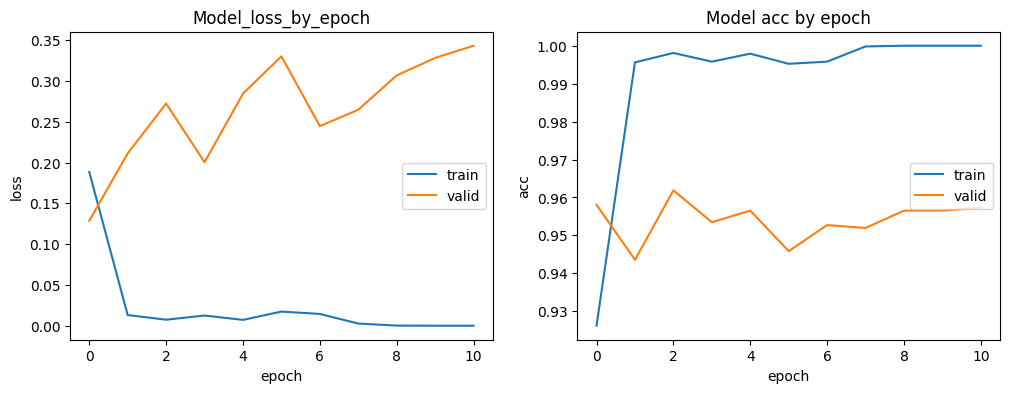

In [17]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model_loss_by_epoch")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

# 4. Détection des anomalies

In [18]:
# Évaluer le modèle sur les données de test
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Précision sur les données de test : {test_accuracy * 100:.2f}%")


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9491 - loss: 0.1224
Précision sur les données de test : 95.20%


In [19]:
# Prédire les labels pour de nouveaux échantillons
y_pred = model.predict(X_test)
# Convertir les prédictions en étiquettes (0 ou 1)
y_pred_labels = (y_pred > 0.5).astype(int)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


# 5. Visualisation des résultats

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       362
           1       0.95      0.95      0.95       367

    accuracy                           0.95       729
   macro avg       0.95      0.95      0.95       729
weighted avg       0.95      0.95      0.95       729



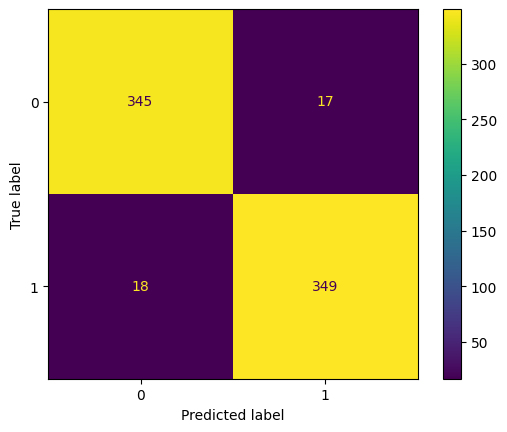

In [20]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
# Calculer et afficher le rapport de classification
print(classification_report(y_test, y_pred_labels))
cm = confusion_matrix(y_test, y_pred=y_pred_labels)
disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


In [21]:
print(model.weights)

model.save('models/Dense_model.keras')

with open('models//scaler.pkl','wb') as f:
    pickle.dump(sc, f)

with open('models//pca.pkl','wb') as f:
    pickle.dump(pca, f)

[<KerasVariable shape=(4000, 1024), dtype=float32, path=sequential_3/dense_18/kernel>, <KerasVariable shape=(1024,), dtype=float32, path=sequential_3/dense_18/bias>, <KerasVariable shape=(1024, 512), dtype=float32, path=sequential_3/dense_19/kernel>, <KerasVariable shape=(512,), dtype=float32, path=sequential_3/dense_19/bias>, <KerasVariable shape=(512, 256), dtype=float32, path=sequential_3/dense_20/kernel>, <KerasVariable shape=(256,), dtype=float32, path=sequential_3/dense_20/bias>, <KerasVariable shape=(256, 128), dtype=float32, path=sequential_3/dense_21/kernel>, <KerasVariable shape=(128,), dtype=float32, path=sequential_3/dense_21/bias>, <KerasVariable shape=(128, 32), dtype=float32, path=sequential_3/dense_22/kernel>, <KerasVariable shape=(32,), dtype=float32, path=sequential_3/dense_22/bias>, <KerasVariable shape=(32, 1), dtype=float32, path=sequential_3/dense_23/kernel>, <KerasVariable shape=(1,), dtype=float32, path=sequential_3/dense_23/bias>]
